In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
hate_data = pd.read_csv("./hate_speech_binary_dataset.csv", delimiter=",") # 혐오 문장
genderbias_data = pd.read_csv('./genderbias.csv', sep=',')  # 여성 비하 문장
ilbe_data = pd.read_csv('./badword.csv',encoding='CP949') # 일베 문장

In [3]:
# 혐오 문장 처리
hate_data.columns = ['comment', 'label_hate'] # 컬럼 명 변경
hate_data = hate_data.astype({'comment': 'str'})
hate_data = hate_data[hate_data['label_hate']==1]

In [4]:
# 여성 비하 문장 처리
del genderbias_data['bias']    #해당 데이터셋의 필요없는 열 제거
del genderbias_data['hate']    #해당 데이터셋의 필요없는 열 제거
genderbias_data['contain_gender_bias'] = genderbias_data['contain_gender_bias'].replace([False, True],[0,1])  # 구분하기 쉽게 기존의 표기를 0,1로 변경
# genderbias_data = genderbias_data[['contain_gender_bias', 'comments']]    #구분하기 쉽게 열의 순서를 변경

genderbias_data.columns = ['comment', 'label_genderbias'] # 컬럼 명 변경
genderbias_data = genderbias_data[genderbias_data['label_genderbias']==1]



In [5]:
# 일베 문장 처리
ilbe_data = ilbe_data[['v2', 'v1']]    #구분하기 쉽게 열의 순서를 변경
ilbe_data.columns = ['comment', 'label_ilbe'] # 컬럼 명 변경
ilbe_data = ilbe_data[ilbe_data['label_ilbe']==1]

In [6]:
hate_data

,comment,label_hate
0,정말 재밌다 연기도 좋고 디카프리오 짱,1
1,심쿵심쿵 미치네요이수혁땜에 잠 못자겠어요ㅠ자꾸 아른거림ㅠ,1
4,"진짜 평점 믿으면 안된 다는 걸 현실로 보여주는 영화입니다. 네티즌,전문가 하나같이...",1
6,후!!!!!!!!!!! 쩔었다...,1
7,오랜만에 휴가내서 조카들 데리고 보고나왔어요 !! 조카들이 너무 좋아해서 평점 10...,1
...,...,...
189991,재밌다. 그만하면 식스센스도 아니구 괜찮은 내용전개고 짜임새있다.,1
189992,그들의 셋의 몽상은 각기다른 몽상이다. 국가와 대항하지만 결국 그것들의 일부분인 테...,1
189994,드라마도 완전 재밌고 배우들도 멋있어서~,1
189995,원작을 읽을 때 이런 건 절대 영상화하기 힘들다고 생각했는데 벤휘쇼의 연기와 더불어...,1


In [7]:
genderbias_data

,comment,label_genderbias
4,1. 사람 얼굴 손톱으로 긁은것은 인격살해이고2. 동영상이 몰카냐? 메걸리안들 생각...,1
6,"100년안에 남녀간 성전쟁 한번 크게 치룬 후 일부다처제, 여성의 정치참여 금지, ...",1
19,180이하 호빗 한남들은 결혼 하지마셈 ㅋ 돈없으면 연애도 하지마셈 ㅋ 니들 호빗 ...,1
33,"2,30대 골빈여자들은 이 기사에 다 모이는건가ㅋㅋㅋㅋ 이래서 여자는 투표권 주면 ...",1
45,20대 30대 남자 비율보소 ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ할짓 드럽게없나봐.....,1
...,...,...
7854,효린아 이쁘고 잘나가는 니가 참아라 저런 면상도 못 까서 뒤에서 징징대는 쿵 쾅이들...,1
7859,휴.. 연하남? 이종석이 결정했다면 보기야 하겠지만 스토리보니 여주위주 또 남주는 ...,1
7863,흐음.. 현아랑 이던 서로 성관계를 가졌을까요?,1
7879,히잌! 기저귀 찬 년들이 군대 군대 주댕이 털고 자빠졌노ㅋ( ° ͜ʖ͡°)╭∩╮,1


In [8]:
ilbe_data

,comment,label_ilbe
0,좌배 까는건 ㅇㅂ,1
2,개소리야 니가 빨갱이를 옹호하고 드루킹을 ㅇㅇ짓이라고 말못해서 삐진거야 빨갱아,1
4,애새끼가 초딩도 아니고 ㅋㅋㅋㅋ,1
5,731부대의 후예라 그런지 가학적인 아이디어는 세계최고임 이래서 애교만 떨어도 돈 ...,1
6,재앙이한건햇노,1
...,...,...
5812,진짜 저 개성없는 머리는 왜 하는거냐,1
5813,오나1홀도 애1무 잘해주면 물 나온다 함 해보라ㅏ,1
5814,좀있으면 100억도 나오겠네 시발 ㅋㅋㅋㅋㅋㅋ,1
5819,세금 내놓으라고 데모질 중 ㅋㅋ간첩 도둑놈 새끼들이 대통령 해처먹으니까 나도 같...,1


## 중복 및 null 처리

In [9]:
def detect_overlap(data):
    exist_overlap = len(data)  # 데이터 전체 개수
    no_overlap = data['comment'].nunique()  # 중복 제거된 개수
    if exist_overlap != no_overlap:
        data.drop_duplicates(subset=['comment'], inplace=True)

In [10]:
detect_overlap(hate_data)
detect_overlap(genderbias_data)
detect_overlap(ilbe_data)

In [11]:
# null 값 확인
genderbias_data.isnull().values.any()
hate_data.isnull().values.any()
ilbe_data.isnull().values.any()

False

## 토큰화

In [12]:
def tokenize(x_data, tokenizer):
    tokenizer.fit_on_texts(x_data) # 데이터의 각 행별로 토큰화 수행
    return tokenizer.texts_to_sequences(x_data)    

In [13]:
x_hatedata = hate_data['comment']
y_hatedata = hate_data['label_hate']

x_genderbiasdata = genderbias_data['comment']
y_genderbiasdata = genderbias_data['label_genderbias']

x_ilbedata = ilbe_data['comment']
y_ilbedata = ilbe_data['label_ilbe']

In [14]:
tokenizer_hate = Tokenizer()
sequences_hate = tokenize(x_hatedata, tokenizer_hate)

tokenizer_genderbias = Tokenizer()
sequences_genderbias = tokenize(x_genderbiasdata, tokenizer_genderbias)

tokenizer_ilbe = Tokenizer()
sequences_ilbe = tokenize(x_ilbedata, tokenizer_ilbe)

## 희귀단어 확인

In [17]:
def detect_rareword(tokenizer, threshold):
    word_to_index = tokenizer.word_index 
    total_cnt = len(word_to_index) # 단어의 수
    rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
    total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
    rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

    # 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
    for key, value in tokenizer.word_counts.items():
        total_freq = total_freq + value

        # 단어의 등장 빈도수가 threshold보다 작으면
        if(value < threshold):
            rare_cnt = rare_cnt + 1
            rare_freq = rare_freq + value

    print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
    print("단어 집합(vocabulary)에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
    print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)
    

In [18]:
# 희귀 단어 확인
detect_rareword(tokenizer_hate, 2)
detect_rareword(tokenizer_genderbias, 2)
detect_rareword(tokenizer_ilbe, 2)

등장 빈도가 1번 이하인 희귀 단어의 수: 149985
단어 집합(vocabulary)에서 희귀 단어의 비율: 75.64112262652243
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 19.47348808947275
등장 빈도가 1번 이하인 희귀 단어의 수: 7544
단어 집합(vocabulary)에서 희귀 단어의 비율: 85.92255125284738
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 59.08521303258145
등장 빈도가 1번 이하인 희귀 단어의 수: 11840
단어 집합(vocabulary)에서 희귀 단어의 비율: 85.64195298372513
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 57.06574127626759


## 훈련 데이터, 테스트 데이터 분리

In [21]:
# 가장 긴 길이
def max_length(X_data):
    return max(len(l) for l in X_data)

# 훈련 학습 데이터 개수
def num_dataset(raio, X_data):
    num_train = int(len(X_data)*0.8)
    num_test = int(len(X_data) - num_train)
    return num_train, num_test

# 훈련 및 학습 데이터 분리
def config_dataset(num_train, data):
    X_test = data[num_train:] #X_data 데이터 중에서 뒤의 개의 데이터만 저장
    y_test = np.array(y_data[num_train:]) #y_data 데이터 중에서 뒤의 개의 데이터만 저장
    X_train = data[:num_train] #X_data 데이터 중에서 앞의 n_of_train개의 데이터만 저장
    y_train = np.array(y_data[:num_train]) #y_data 데이터 중에서 앞의 n_of_train개의 데이터만 저장
    
    return X_test, y_test, X_train, y_train

In [22]:
# 최대 길이 계산
X_hatedata = sequences_hate
maxlen_hate = max_length(X_hatedata)

X_genderbiasdata = sequences_genderbias
maxlen_genderbias = max_length(X_genderbiasdata)

X_ilbedata = sequences_ilbe
maxlen_ilbe = max_length(X_ilbedata)


## 문장 길이 분포 확인

혐오 문장 최대 길이 : 59
혐오 문장 평균 길이 : 7.918420


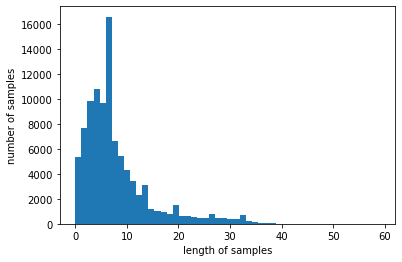

In [24]:
print('혐오 문장 최대 길이 : %d' % max(len(l) for l in X_hatedata))
print('혐오 문장 평균 길이 : %f' % (sum(map(len, X_hatedata))/len(X_hatedata)))
plt.hist([len(s) for s in X_hatedata], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

여성 비하 문장 최대 길이 : 32
여성 비하 문장 평균 길이 : 10.363636


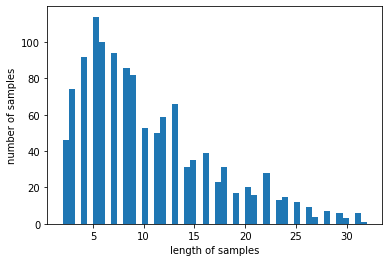

In [25]:
print('여성 비하 문장 최대 길이 : %d' % max(len(l) for l in X_genderbiasdata))
print('여성 비하 문장 평균 길이 : %f' % (sum(map(len, X_genderbiasdata))/len(X_genderbiasdata)))
plt.hist([len(s) for s in X_genderbiasdata], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

일베 문장 최대 길이 : 194
일베 비하 문장 평균 길이 : 10.150685


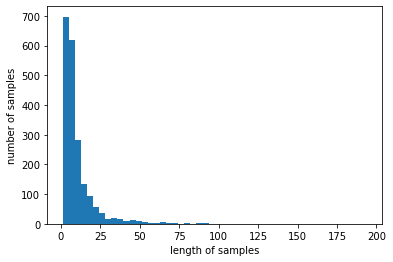

In [26]:
print('일베 문장 최대 길이 : %d' % max(len(l) for l in X_ilbedata))
print('일베 비하 문장 평균 길이 : %f' % (sum(map(len, X_ilbedata))/len(X_ilbedata)))
plt.hist([len(s) for s in X_ilbedata], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

## 훈련 데이터, 학습 데이터 분할

In [291]:
# 훈련 및 학습 데이터 개수 비율 지정

numtrain_hate, numtest_hate = num_dataset(0.8, X_hatedata)
numtrain_genderbias, numtest_genderbias = num_dataset(0.8, X_genderbiasdata)
numtrain_ilbe, numtest_ilbe = num_dataset(0.8, X_ilbedata)

In [292]:
# 가장 긴 길이로 맞추기
hatedata = pad_sequences(X_hatedata, maxlen = maxlen_hate)
genderbiasdata = pad_sequences(X_genderbiasdata, maxlen = maxlen_genderbias)
ilbedata = pad_sequences(X_ilbedata, maxlen = maxlen_ilbe)

In [293]:
X_hatetest, y_hatetest, X_hatetrain, y_hatetrain = config_dataset(numtrain_hate, hatedata)
X_genderbiastest, y_genderbiastest, X_genderbiastrain, y_genderbiastrain = config_dataset(numtrain_genderbias, genderbiasdata)
X_ilbetest, y_ilbetest, X_ilbetrain, y_ilbetrain = config_dataset(numtrain_ilbe, ilbedata)